# 4. Modelling

1. Importing packages and dataset
2. Pre-assesment of multiple regression models
3. Feature selection
4. Hyperparameter tuning for selected models
5. Final model selection and results

## 4.1. Importing packages and dataset

In [1]:
# Import the required packages

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, explained_variance_score

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
# Import processed train and test sets and load them in dataframes

# Assign paths variable
X_train_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/X_train.csv'
X_test_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/X_test.csv'
y_train_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/y_train.csv'
y_test_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/y_test.csv'

# Load csv in dataframe
X_train = pd.read_csv(X_train_path, index_col=0)
X_test = pd.read_csv(X_test_path, index_col=0)
y_train = pd.read_csv(y_train_path, index_col=0)
y_test = pd.read_csv(y_test_path, index_col=0)

In [3]:
# Import original un-processed dataset for further unscaling and interpretation of data

file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/interim/clean.csv'
orig_df = pd.read_csv(file, index_col=0)

In [4]:
# Check # of columns and rows imported
X_train.shape

(3980, 48)

In [5]:
X_test.shape

(1706, 48)

In [6]:
y_train.head()

,COOL_COST_log,HEAT_COST_log,WATERHEAT_COST_log,ELECT_COST_log,TOT_COST_log
4209,5.749074,6.993841,5.958037,6.699931,7.863267
2209,5.959509,6.527636,5.677678,7.274084,7.938410
773,6.564293,5.576441,4.140114,7.045027,7.687259
978,0.000000,7.134126,5.958528,7.180458,7.990438
2010,3.736955,4.361951,5.203072,6.987878,7.231743


## 4.2. Pre-assesment of multiple regression models

In this section multiple regression algorithms will be tested with default configuration to obtain a general idea of their performance with our dataset. For this exercise we are not using cross-validation or adjusting any hyperparameter since the objective is simply to understand which algorithm would be the most adequate for predicting our target variables.

The algorithms to be tested are the following:
- Linear Regression (OLS)
- Linear Regression with L2 regularization - Ridge
- Linear Regression with L1 regularization - Lasso
- Bagging ensemble method - Random Forest Regressor
- Boosting ensemble method - Gradient Boosting Regressor

The target variables are numerical and continuous, and because their original distribution had a long right tail a logarhitmic transformation was applied to recenter the distribution. Therefore, the out-of-box functions to calculate different performance metrics cannot be applied, namely the mean absolute error score.

We will have to create our own custom function to calculate this metric.

In [7]:
# Create function to compute mean absolute error

def MAE(y_true, y_pred):
    '''Computes mean absolute error in real value from a log transformed variable'''
    diff = 0
    for i in range(len(y_true)):
        diff += abs(np.exp(y_pred[i]) - np.exp(y_true.iloc[i,0]))
    
    mae = round(float(diff/len(y_true)), 2)
    return mae

In [8]:
# Create fuction to assess performance of different models with our data

def model_performance(reg_models, X_train, X_test, y_train, y_test):
    '''Evaluate regression models performance with default hyperparameters on a dataset'''
    exp_var = []
    mae = []
    
    for model in reg_models:
        m = model()
        m_fit = m.fit(X_train, y_train)
        y_pred = m_fit.predict(X_test)
        
        # Compute explained variance score and mean absolute error
        exp_var.append(round(explained_variance_score(y_test, y_pred),3))
        m = MAE(y_test, y_pred)
        
        # Undo log transformation to get meaningful mean errors
        mae.append(m)

    # Get name of the models
    models = [re.findall(r'\w+', str(i))[-1] for i in reg_models] 
    
    # Create df with results
    df = pd.DataFrame({'model':models, 'exp_var':exp_var, 'mean_abs_error':mae})
    
    return df

In [9]:
# Select the models to test
models = [LinearRegression, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor]

# Define target variables, one for each type of energy use type plus the combined total
y_train_COOL = y_train[['COOL_COST_log']]
y_train_HEAT = y_train[['HEAT_COST_log']]
y_train_WATER = y_train[['WATERHEAT_COST_log']]
y_train_ELEC = y_train[['ELECT_COST_log']]
y_train_TOT = y_train[['TOT_COST_log']]

y_test_COOL = y_test[['COOL_COST_log']]
y_test_HEAT = y_test[['HEAT_COST_log']]
y_test_WATER = y_test[['WATERHEAT_COST_log']]
y_test_ELEC = y_test[['ELECT_COST_log']]
y_test_TOT = y_test[['TOT_COST_log']]

# Run the tests and store the dfs with the results
r1 = model_performance(models, X_train, X_test, y_train_COOL, y_test_COOL)
r2 = model_performance(models, X_train, X_test, y_train_HEAT, y_test_HEAT)
r3 = model_performance(models, X_train, X_test, y_train_WATER, y_test_WATER)
r4 = model_performance(models, X_train, X_test, y_train_ELEC, y_test_ELEC)
r5 = model_performance(models, X_train, X_test, y_train_TOT, y_test_TOT)

In [10]:
# Merge results and print them

results = r1.merge(r2, on='model').merge(r3, on='model').merge(r4, on='model').merge(r5, on='model')
results.columns = ['model', 
                   'cool_cost_exp_var', 'cool_cost_mae',
                   'heat_cost_exp_var', 'heat_cost_mae',
                   'water_heating_exp_var', 'water_heating_mae',
                   'elect_cost_exp_var', 'elect_cost_mae',
                   'total_cost_exp_var', 'total_cost_mae'
                  ]

results

,model,cool_cost_exp_var,cool_cost_mae,heat_cost_exp_var,heat_cost_mae,water_heating_exp_var,water_heating_mae,elect_cost_exp_var,elect_cost_mae,total_cost_exp_var,total_cost_mae
0,LinearRegression,0.897,100.09,0.698,249.22,0.113,132.43,0.257,437.00,0.390,725.71
1,Ridge,0.897,100.15,0.698,248.80,0.114,132.38,0.258,436.70,0.390,725.31
2,Lasso,0.000,190.81,0.000,358.35,0.000,142.45,0.000,509.57,0.000,909.53
3,RandomForestRegressor,0.909,102.08,0.687,249.75,0.067,135.61,0.226,439.15,0.368,737.58
4,GradientBoostingRegressor,0.914,100.07,0.712,247.14,0.129,131.84,0.255,434.51,0.398,719.39


In [11]:
# Print median values for each of the target variables for comparison with mean absolute error

k = orig_df[['COOL_COST_log', 'HEAT_COST_log', 'WATERHEAT_COST_log', 'ELECT_COST_log', 'TOT_COST_log']]

median_val = pd.DataFrame(round(np.exp(k.describe().iloc[[3,5,7], :])-1, 2)).T.reset_index().rename(columns={'index':'Target variable', 'min':'Min', '50%':'Median', 'max':'Max'})

median_val

,Target variable,Min,Median,Max
0,COOL_COST_log,0.00,146.60,2860.01
1,HEAT_COST_log,0.00,400.84,4766.66
2,WATERHEAT_COST_log,0.00,236.44,2566.61
3,ELECT_COST_log,15.43,1021.74,7310.58
4,TOT_COST_log,76.40,1997.59,11078.48


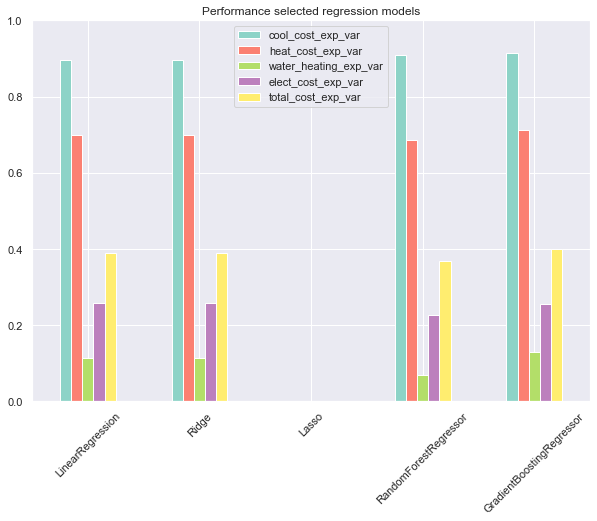

In [12]:
# Plot explained variance results

expl_var_results = results[['model', 'cool_cost_exp_var', 'heat_cost_exp_var', 
                            'water_heating_exp_var', 'elect_cost_exp_var', 'total_cost_exp_var']]
                           
expl_var_results.plot.bar(x='model', cmap='Set3', figsize=(10,7))
plt.title('Performance selected regression models', fontsize=12)
plt.ylim([0,1])
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper center')
plt.tight_layout
plt.show()

__Conclusions of this section:__

Initial results show that the Gradient Boosting ensemble algorithm yields the best explained variance score in Cooling, Heating, Water Heating and Total cost target variables, whereas Ridge Regression algorithm score slighly better for Other Electricity. However, in general all algorithms tested scored rather low for Water-Heating-Costs and Other-Electrical-Costs, which means that those response variables are hardly explained by any algorithm. Besides, the best model explains ~40% of the target variable variance which is roughly an average of the other four compounding response variables. 

The most significant outcome of this assessment is that the mean error is so high compared to the median value that limits the utility of this prediction tool for a potential user. 

Regardless of this circumstances, in next sections we will select the most relevant features and adjust the model's  hyperparameters to try to improve predictive power.

We will choose Gradient Boosting algorithm to predict all target variables for the sake of convenience.

## 4.3. Feature selection

Once we know which model will use to predict each response variable, we will optimize the feature space by removing higly correlated columns and features which are irrelevant for the regression model. 

Firstly, we will check and remove any highly correlated features to reduce dimensionality: 

In [13]:
# Create function to select and remove highly correlated features

def remove_corr_feat(df):
    '''Selects and remove highly correlated features'''
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of the matrix, since it is symmetric
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    
    # Select columns with correlation coefficient higher than 0.95
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    # Drop correlated features
    dfo = df.drop(to_drop, axis=1)
    
    return dfo   

In [14]:
# Remove highly correlated features from train set

X_train = remove_corr_feat(X_train)
X_train.shape

(3980, 46)

In [15]:
# Remove highly correlated features from test set

X_test = remove_corr_feat(X_test)
X_test.shape

(1706, 46)

It can be seen that 2 highly colinear features have been removed with this operation. 

Further, we will optimize the number of features based on its explained variance. A Recursive Feature Elimination algorithm will automatically tune of the number of features selected with cross-validation for each target variable:

In [16]:
# Import package 
from sklearn.feature_selection import RFECV

# Define fucntion for feature selection
def cv_feature_selection(estimator, X, y):
    '''Selectcs optimal features based on mean absolute error'''
    rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='explained_variance', n_jobs=-1)
    rfecv.fit(X, y)

    rfecv_mask = rfecv.get_support()
    
    rfecv_features = [] 
    for bool, feature in zip(rfecv_mask, X_train.columns):
        if bool:
            rfecv_features.append(feature)

    return rfecv_features

In [17]:
# Create function to check features removed

def Diff(li1, li2):
    '''Computes differences between two lists'''
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

In [18]:
# Instantiate regressor for feature selection
reg = GradientBoostingRegressor()

#### Feature selection for *Cooling Costs*:

In [ ]:
# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_COOL)

print('Optimal number of features :', len(sel_features))

X_train_COOL = X_train[sel_features]
X_test_COOL = X_test[sel_features]

In [ ]:
# Check features removed
Diff(sel_features, list(X_train.columns))

#### Feature selection for *Heating Costs*:

In [ ]:
# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_HEAT)

print('Optimal number of features :', len(sel_features))

X_train_HEAT = X_train[sel_features]
X_test_HEAT = X_test[sel_features]

In [ ]:
# Check features removed
Diff(sel_features, list(X_train.columns))

#### Feature selection for *Water Heating Costs*:

In [ ]:
# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_WATER)

print('Optimal number of features :', len(sel_features))

X_train_WATER = X_train[sel_features]
X_test_WATER = X_test[sel_features]

In [ ]:
# Check features removed
Diff(sel_features, list(X_train.columns))

#### Feature selection for *Other Electricity Costs*:

In [ ]:
# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_ELEC)

print('Optimal number of features :', len(sel_features))

X_train_ELEC = X_train[sel_features]
X_test_ELEC = X_test[sel_features]

In [ ]:
# Check features removed
Diff(sel_features, list(X_train.columns))

#### Feature selection for *Total Utility Costs*:

In [ ]:
# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_TOT)

print('Optimal number of features :', len(sel_features))

X_train_TOT = X_train[sel_features]
X_test_TOT = X_test[sel_features]

In [ ]:
# Check features removed
Diff(sel_features, list(X_train.columns))

## 4.4. Hyperparameter tuning for selected models

In this section, we will tune the hyperparameters of the Gradient Boosting and Ridge algorithms to find the best model for each of the variables. To do this we will use a grid search algorithm with cross-validation.

__Gradient Boosting Regressor__

The following parameters will be tested and adjusted:
- *Max Depth*: maximum number of levels the trees can grow
- *Number of Estimators*: number of boosting stages
- *Learning Rate*: the level of the contribution of each tree to the final model

In [19]:
# Import GridSearch
from sklearn.model_selection import GridSearchCV

In [20]:
# Create function for grid search and cross-validation

def best_config(model, param_grid, X_train, y_train):
    '''Runs a grid search with cross-validation for selected model and datasets'''
    estimator = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    estimator_fit = estimator.fit(X_train, y_train)
    
    # Get 5 best models and their scores
    r = pd.DataFrame({'Best params':estimator_fit.cv_results_['params'][estimator_fit.best_index_], 
                      'Best score':estimator_fit.best_score_})
    
    return r

In [21]:
# Instantiate the regressor for hyperparameter tuning

gbr = GradientBoostingRegressor()

In [22]:
# Select hyperparameters to tune 

param_grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2],
              'max_depth': [2, 3, 4], 
              'n_estimators': [150, 200, 250]
             }

#### Hyperparameter tune for *Cooling Costs*:

In [23]:
# Get best hyperparams and score

best_config(gbr, param_grid, X_train, y_train_COOL)

,Best params,Best score
learning_rate,0.05,0.905716
max_depth,4.00,0.905716
n_estimators,200.00,0.905716


#### Hyperparameter tune for *Heating Costs*:

In [24]:
# Get best hyperparams and score

best_config(gbr, param_grid, X_train, y_train_HEAT)

,Best params,Best score
learning_rate,0.1,0.673897
max_depth,2.0,0.673897
n_estimators,200.0,0.673897


#### Hyperparameter tune for *Water Heating Costs*:

In [25]:
# Get best hyperparams and score

best_config(gbr, param_grid, X_train, y_train_WATER)

,Best params,Best score
learning_rate,0.15,0.127294
max_depth,2.00,0.127294
n_estimators,150.00,0.127294


#### Hyperparameter tune for *Other Electricity Costs*:

In [26]:
# Get best hyperparams and score

best_config(gbr, param_grid, X_train, y_train_ELEC)

,Best params,Best score
learning_rate,0.05,0.275731
max_depth,3.00,0.275731
n_estimators,250.00,0.275731


#### Hyperparameter tune for *Total Utility Costs*:

In [27]:
# Get best hyperparams and score

best_config(gbr, param_grid, X_train, y_train_TOT)

,Best params,Best score
learning_rate,0.15,0.406615
max_depth,2.00,0.406615
n_estimators,150.00,0.406615


## 4.5. Final model selection and results

Once we have compute performance for different hyperparameter configurations, we can run the final model selection for each of the target variables and review the explained variance and mean absolute error score results. 

As we saw in the previous section, the most optimal configurations are:

| Target variable | Learning rate | Max depth | Number of estimators (trees) |
| -------- | --------- | --------- | --------- |
| Cooling costs | 0.05 | 4 | 200 |
| Heating costs | 0.1 | 2 | 200 |
| Waterheating costs | 0.15 | 2 | 150 |
| Other electricity costs | 0.05 | 3 | 250 |
| Total costs | 0.15 | 2 | 150 |

Also, we will calculate the upper limit prediction interval and provide the maximum utility expenses probability for a given house/unit. This is useful for potential user since it limits the uncertainty of the model by giving a likely maximum expense. 

The upper prediction interval certanty is been set to 0.80, meaning that 80% of the real values are expected to lay below the given prediction.

In [28]:
# Create fuction to get explained variand and mean absolute error

def model_scoring(y_test, y_pred):
    '''Get explained variance and mean absolute error with real unscaled values'''
        
    # Compute explained variance score and mean absolute error
    exp_var = round(explained_variance_score(y_test, y_pred),3)
    mae = MAE(y_test, y_pred)

    return exp_var, mae

In [29]:
# Create empty lists to store results

exp_var = []
mae = []
feat = ['cooling cost', 'heating cost', 'water heating cost', 'other electricity cost', 'total utility cost']

In [30]:
# Set upper confidence interval

upper_alpha=0.80

#### Final model for *Cooling Cost* prediction:

In [31]:
# Instantiate predictor
gbr_cool = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=200)

# Fit and predict
gbr_cool_fit = gbr_cool.fit(X_train, y_train_COOL)
y_pred = gbr_cool_fit.predict(X_test)

In [32]:
# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_COOL, y_pred)

# Store results in lists
exp_var.append(ev)
mae.append(m)

In [33]:
# Get upper prediction interval

# Instantiate predictor
gbr_int_cool = GradientBoostingRegressor(loss="quantile", alpha=upper_alpha, learning_rate=0.05, max_depth=4, n_estimators=200)

# Fit and predict
gbr_int_cool_fit = gbr_int_cool.fit(X_train, y_train_COOL)

__Final model for *Heating Cost* prediction:__

In [34]:
# Instantiate predictor
gbr_heat = GradientBoostingRegressor(learning_rate=0.1, max_depth=2, n_estimators=200)

# Fit and predict
gbr_heat_fit = gbr_heat.fit(X_train, y_train_HEAT)
y_pred = gbr_heat_fit.predict(X_test)

In [35]:
# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_HEAT, y_pred)

# Store results in lists
exp_var.append(ev)
mae.append(m)

In [36]:
# Get upper prediction interval

# Instantiate predictor
gbr_int_heat = GradientBoostingRegressor(loss="quantile", alpha=upper_alpha, learning_rate=0.1, max_depth=2, n_estimators=200)

# Fit and predict
gbr_int_heat_fit = gbr_int_heat.fit(X_train, y_train_HEAT)

__Final model for *Water Heating Cost* prediction:__

In [37]:
# Instantiate predictor
gbr_wat = GradientBoostingRegressor(learning_rate=0.15, max_depth=2, n_estimators=150)

# Fit and predict
gbr_wat_fit = gbr_wat.fit(X_train, y_train_WATER)
y_pred = gbr_wat_fit.predict(X_test)

In [38]:
# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_WATER, y_pred)

# Store results in lists
exp_var.append(ev)
mae.append(m)

In [39]:
# Get upper prediction interval

# Instantiate predictor
gbr_int_wat = GradientBoostingRegressor(loss="quantile", alpha=upper_alpha, learning_rate=0.15, max_depth=2, n_estimators=150)

# Fit and predict
gbr_int_wat_fit = gbr_int_wat.fit(X_train, y_train_WATER)

__Final model for *Other Electricity Cost* prediction:__

In [40]:
# Instantiate predictor
gbr_elec = GradientBoostingRegressor(learning_rate=0.05, max_depth=3, n_estimators=250)

# Fit and predict
gbr_elec_fit = gbr_elec.fit(X_train, y_train_ELEC)
y_pred = gbr_elec_fit.predict(X_test)

In [41]:
# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_ELEC, y_pred)

# Store results in lists
exp_var.append(ev)
mae.append(m)

In [42]:
# Get upper prediction interval

# Instantiate predictor
gbr_int_elec = GradientBoostingRegressor(loss="quantile", alpha=upper_alpha, learning_rate=0.05, max_depth=3, n_estimators=250)

# Fit and predict
gbr_int_elec_fit = gbr_int_elec.fit(X_train, y_train_ELEC)

__Final model for *Total Cost* prediction:__

In [43]:
# Instantiate predictor
gbr_tot = GradientBoostingRegressor(learning_rate=0.15, max_depth=2, n_estimators=150)

# Fit and predict
gbr_tot_fit = gbr_tot.fit(X_train, y_train_TOT)
y_pred = gbr_tot_fit.predict(X_test)

In [44]:
# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_TOT, y_pred)

# Store results in lists
exp_var.append(ev)
mae.append(m)

In [45]:
# Get upper prediction interval

# Instantiate predictor
gbr_int_tot = GradientBoostingRegressor(loss="quantile", alpha=upper_alpha, learning_rate=0.15, max_depth=2, n_estimators=150)

# Fit and predict
gbr_int_tot_fit = gbr_int_tot.fit(X_train, y_train_TOT)

Finally, the performance scores of final models are shown in the table below:

In [46]:
# Create dataframe with all results

final_results = pd.DataFrame({'features':feat, 'explained variance':exp_var, 'MAE':mae}).join(median_val[['Min', 'Median', 'Max']], how='left')
final_results

,features,explained variance,MAE,Min,Median,Max
0,cooling cost,0.915,99.22,0.00,146.60,2860.01
1,heating cost,0.708,247.07,0.00,400.84,4766.66
2,water heating cost,0.137,131.69,0.00,236.44,2566.61
3,other electricity cost,0.252,435.54,15.43,1021.74,7310.58
4,total utility cost,0.397,719.76,76.40,1997.59,11078.48


__Explained variance:__

It can be seen a large difference in model performance between target variables prediction. Although they are all related to energy consumption, there are significant differences in how the source of energy is used. 

Space heating and cooling in residential units is achieved by a energy flow balance between external climate conditions (temperature, humidity, etc.) and internal confort conditions. Broadly speaking, in cold climates there is an energy inlet from a building system and a energy outlet through the building envelope (facade, windows, etc.), and the opposite for hot climates. Therefore, Heating and Cooling consumption costs are largely driven by climate region, and construction and building system features, which is the bulk of our dataset.

Some features have particularly high weight on cooling and heating value prediction:
- Climate zone
- Unit type
- Building age (which is a proxy for insulation level)
- Square footage

In regard to water heating cost, its consumption is more driven by number of household members and their behaviour rather than any other feature. Since social and behavioural information is not available in our dataset, little target variance can be explained with our data and model. Nevertheless, number of bedrooms and bathrooms do provide some information about the variance of water heating cost, they might be representing a proxy for hosehold. 
Please note that this response variable accounts for the energy spent on water heating and not the water consumption itself. 

When it comes to other electicity costs, this target variable is hardly explained by any building intrinsic features, instead it is more likely driven by the energy intensity of the unit, which means the number of electric appliances and ligting and their usage pattern. However, just like happens with water heating cost, number of bedrooms, bathrooms, and square footage add some value to the prediction, which makes sense since the larger the unit's area the more appliances and lighting it contains.

Total energy cost variable is a simple addition of all other energy consumption types. Predicting this feature is also interesting since the errors from individual prediction could be offset among them.

__Error:__

Prediction error measured by mean-absolute-error score is significantly high in comparison with median values in the test set even in Cooling Cost variable. This might be explained by the spread of the distribution of the target variables, the long right tail values could be outweighing in the mean error.

Besides, some other error in the target variable is also due to different energy costs nationwide. All the selected features in our dataset are intended to provide insights on the level of energy consumption, but our final target variables which are useful for the final user are final dolar cost. 

## Save models for deployment

The models will be saved for further deployment in the production application

In [47]:
#import pickle
#s = pickle.dumps(model1)

from joblib import dump, load

dump(gbr_cool_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_coolingcosts.joblib') 
dump(gbr_int_cool_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_coolingcosts_upperinter.joblib')

dump(gbr_heat_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_heatingcosts.joblib') 
dump(gbr_int_heat_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_heatingcosts_upperinter.joblib')

dump(gbr_wat_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_waterheatingcosts.joblib') 
dump(gbr_int_wat_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_waterheatingcosts_upperinter.joblib')

dump(gbr_elec_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_electricitycosts.joblib') 
dump(gbr_int_elec_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_electricitycosts_upperinter.joblib')

dump(gbr_tot_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_totalcosts.joblib') 
dump(gbr_int_tot_fit, 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_totalcosts_upperinter.joblib')

['C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/models/model_totalcosts_upperinter.joblib']